In [1]:
%matplotlib nbagg
import numpy as np
import json
import os
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from IPython.display import clear_output, display

from alvra_tools.load_data import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *
from alvra_tools.utils import errfunc_sigma, errfunc_fwhm

In [44]:
#scan_name ="YAG_FEL0.2_2605_021"
scan_name ="time-scan-pink"
scan_range =".run001838-001859"
#timing_YAG_2.56keV.

#DIR = "/sf/alvra/data/p17807/res/scan_data/" + scan_name + "/"
DIR = "/sf/alvra/data/p18387/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p18387/res/scan_info/"

In [45]:
!ls -la -rt $DIR | grep BSREAD.h5


!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

-rw-r--r--.  1 root p18387 139506319 Feb 21 19:43 run_001556.BSREAD.h5
-rw-r--r--.  1 root p18387 139489935 Feb 21 19:43 run_001557.BSREAD.h5
-rw-r--r--.  1 root p18387 139489935 Feb 21 19:43 run_001558.BSREAD.h5
-rw-r--r--.  1 root p18387 139498127 Feb 21 19:44 run_001559.BSREAD.h5
-rw-r--r--.  1 root p18387 139498127 Feb 21 19:44 run_001560.BSREAD.h5
-rw-r--r--.  1 root p18387 139498127 Feb 21 19:44 run_001561.BSREAD.h5
-rw-r--r--.  1 root p18387 139498127 Feb 21 19:45 run_001562.BSREAD.h5
-rw-r--r--.  1 root p18387 139498127 Feb 21 19:46 run_001563.BSREAD.h5
-rw-r--r--.  1 root p18387 139498127 Feb 21 19:46 run_001564.BSREAD.h5
-rw-r--r--.  1 root p18387 139498127 Feb 21 19:46 run_001565.BSREAD.h5
-rw-r--r--.  1 root p18387 139498127 Feb 21 19:46 run_001566.BSREAD.h5
-rw-r--r--.  1 root p18387 139465359 Feb 21 19:46 run_001567.BSREAD.h5
-rw-r--r--.  1 root p18387 139489935 Feb 21 19:46 run_001568.BSREAD.h5
-rw-r--r--.  1 root p18387 139465359 Feb 21 19:47 run_001569.BSREAD.h5
-rw-r-

ra-c-002.psi.ch
There are 340 files in the folder /sf/alvra/data/p18387/raw/scan_data/time-scan-pink/


### Next cell: Signal calculated Shot-to-shot and averaged

In [52]:
print (channel_BS_pulse_ids)

json_file = DIR_json + scan_name + scan_range + ".json"

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
#numFiles = 15
print ("Processing",numFiles,"files")
print (json_file)

Pump_probe = []
Pump_probe_avg =[]
err_pump_probe =[]
Delay_mm = []

Izero_FEL_mean = []
err_Izero_FEL_mean = []
Izero_FEL_all = []
Izero_FEL_all_filter = []

PIPS_mean = []
BAM_mean = []
BAM_error = []

for i in range(0,numFiles):
    filename = str(data['scan_files'][i][0])
    exists = os.path.isfile(filename)

    if (exists) and (i!=12):
        clear_output(wait=True)
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (Laser_pump, Laser_unpump, Laser_ref_pump, Laser_ref_unpump, Izero_FEL, PIPS, delay, pids_loop) = \
        load_YAG_events(str(data['scan_files'][i][0]))
           
        threshold_FEL = Izero_FEL > 0.05
        condition_FEL = Izero_FEL > np.median(Izero_FEL)-2*(np.std(Izero_FEL))
        condition_laser_pump = ((Laser_pump > 10))# & (Laser_ref_pump > 10))
        condition_laser_unpump = ((Laser_unpump > 10))# & (Laser_ref_unpump > 10))
        
        Laser_pump = Laser_pump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Laser_unpump = Laser_unpump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Laser_ref_pump = Laser_ref_pump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Laser_ref_unpump = Laser_ref_unpump[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        Izero_FEL_filter = Izero_FEL[threshold_FEL & condition_FEL & condition_laser_pump & condition_laser_unpump]
        
        print ("Survived after filtering {} shots".format(len(Laser_pump)*2))
        #Laser_diff = -np.log10((Laser_pump/Laser_ref_pump) / (Laser_unpump/ Laser_ref_unpump))
        Laser_diff = -np.log10((Laser_pump) / (Laser_unpump))
        #Laser_diff = ((Laser_pump) / (Laser_unpump))
    
        Pump_probe.append(Laser_diff.mean())
        err_pump_probe.append(Laser_diff.std() / np.sqrt(Laser_diff.size))
        
        Pump = Laser_pump.mean()
        Unpump = Laser_unpump.mean()
        Pump_probe_avg.append(-np.log10((Pump) / (Unpump)))
        
   #    Izero_FEL_all.append(Izero_FEL)
   #    Izero_FEL_mean.append(Izero_FEL.mean())
   #    err_Izero_FEL_mean.append(Izero_FEL.std() / np.sqrt(Izero_FEL.size))
    
        Izero_FEL_all_filter.append(Izero_FEL_filter)  
        Izero_FEL_mean.append(Izero_FEL_filter.mean())
        err_Izero_FEL_mean.append(Izero_FEL_filter.std() / np.sqrt(Izero_FEL_filter.size))
        
        #PIPS_mean.append(PIPS.mean())
        #Delay_mm.append(delay.mean())
        #Delay_mm.append(delay[0])
        Delay_mm.append(data['scan_readbacks'][i]) ## Delay from the json file
        
Pump_probe = np.asarray(Pump_probe)
Pump_probe_avg = np.asarray(Pump_probe_avg)
err_pump_probe = np.asarray(err_pump_probe)

Izero_FEL_mean = np.asarray(Izero_FEL_mean)
err_Izero_FEL_mean = np.asarray(err_Izero_FEL_mean)

Delay_mm = np.asarray(Delay_mm)

step 18 of 20 : Processing /sf/alvra/data/p18387/raw/scan_data/time-scan-pink/run_001855.BSREAD.h5
Found 3999 shots in the file
Load 3998 shots
Pump/umpump arrays have 1998 shots each
Survived after filtering 3820 shots


 ### Plot pump probe signals as a function of delay (stage mm)

<IPython.core.display.Javascript object>


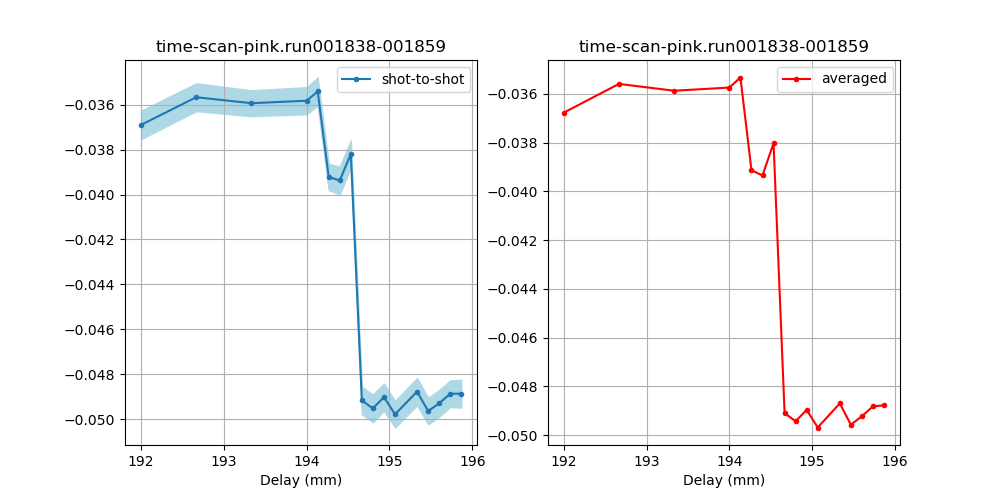

In [53]:
#savedir = "/das/work/p17/p17569/Beamline/"
plt.figure(figsize = (10,5))
plt.subplot(121)
#Pump_probe = Pump_probe/1.007
plt.plot(Delay_mm, Pump_probe, label="shot-to-shot",marker='.')

low_err = Pump_probe - err_pump_probe
high_err = Pump_probe + err_pump_probe
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')
plt.title(scan_name + scan_range)
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()

plt.subplot(122)
plt.plot(Delay_mm, Pump_probe_avg, label="averaged", color = 'r', marker='.')

plt.title(scan_name + scan_range)
plt.xlabel("Delay (mm)")
plt.legend(loc="best")
plt.grid()
plt.show()
#plt.savefig(savedir + 'LAMcheck_026')

 ### Extract t0 from the fit 

In [54]:
Pump_probe_toFit = Pump_probe.copy()
Delay_mm_toFit = np.copy(Delay_mm.ravel())

# Now fit with error funciton
index = ~(np.isnan(Delay_mm_toFit) | np.isnan(Pump_probe_toFit))

parameters,extras = curve_fit(errfunc_fwhm, Delay_mm_toFit[index], Pump_probe_toFit[index], p0 = [-0.05, -0.2, 195, 0.1])
#parameters,extras = curve_fit(errfunc_fwhm, Delay_mm_toFit, Pump_probe_toFit, p0 = [0.01, 0.12, 161, 0.1])

print("Position t0 =",np.round(parameters[2],5),"mm")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"um")

Position t0 = 194.57651 mm
Width = 81.0 um


### Plot the curve with the fit

<IPython.core.display.Javascript object>


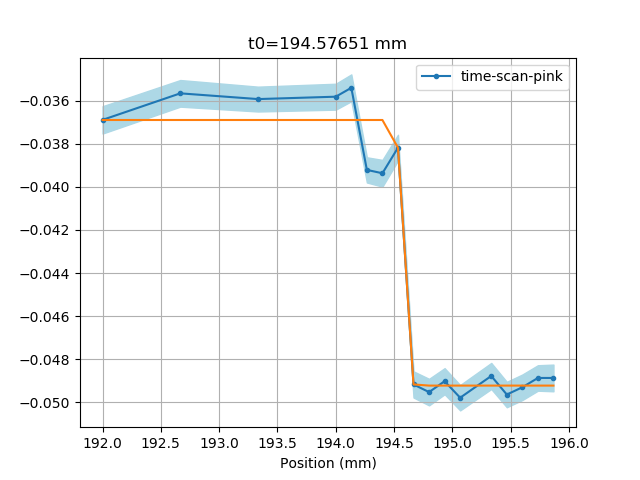

In [55]:
#savedir = "/das/work/p17/p17569/Beamline/"

plt.figure()

plt.plot(Delay_mm_toFit, Pump_probe_toFit, label=f"{scan_name}",marker='.')
plt.plot(Delay_mm_toFit, errfunc_fwhm(Delay_mm_toFit,*parameters))

low_err = Pump_probe - err_pump_probe
high_err = Pump_probe + err_pump_probe
plt.fill_between(np.squeeze(Delay_mm), low_err, high_err, color='lightblue')

plt.title('t0=' + str(np.round(parameters[2], 5)) + ' mm' )
plt.grid()
plt.xlabel("Position (mm)")
plt.legend(loc="best")
plt.show()
#plt.savefig(savedir + 'scan_YAG_007')

### Define a t0 and time axis for time plots afterwards

In [179]:
t0_Time_air = 163.08795

t0_Time_100mbar = 194.6

Delay_ps = 2* (Delay_mm - t0_Time_100mbar)*3.333   # factor of 2 in delay due to the delay stage

 ### Now the fit in time

In [180]:
Delay_ps_toFit = np.copy(Delay_ps.ravel())

# Now fit IN TIME with error funciton (defined above)
index = ~(np.isnan(Delay_ps_toFit) | np.isnan(Pump_probe_toFit))
parameters,extras = curve_fit(errfunc_fwhm, Delay_ps_toFit[index], Pump_probe_toFit[index], p0 = [1.06, 1.076, 0, 100])

yFit=[errfunc_fwhm(x, parameters[0],parameters[1],parameters[2],parameters[3]) for x in Delay_ps_toFit]


print("Position t0 =",np.round(parameters[2],5)*1000,"fs")
print("Width =",np.abs(np.round(parameters[3],3))*1000,"fs")

Position t0 = -149667.30000000002 fs
Width = 61259344.0 fs


### Plot the curve vs time with the fit, referenced to t0 defined above

<IPython.core.display.Javascript object>


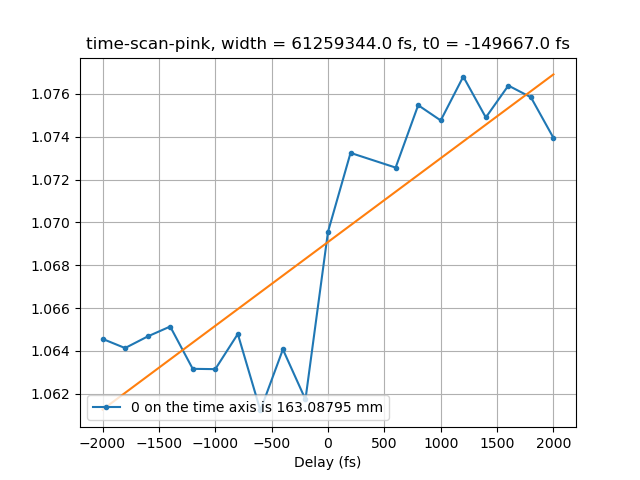

In [181]:

plt.figure()
plt.plot((Delay_ps)*1000, Pump_probe, label="0 on the time axis is %s mm" % t0_Time_air,marker='.')   
plt.plot(Delay_ps_toFit*1000, errfunc_fwhm(Delay_ps_toFit,*parameters))
plt.plot(label='0 in time is')

low_err = Pump_probe - err_pump_probe
high_err = Pump_probe + err_pump_probe
#plt.fill_between(np.squeeze((Delay_ps)*1000), low_err, high_err, color='lightblue')

plt.title(scan_name + ", width = " + str(np.abs(np.round(parameters[3], 3))*1000) + " fs" + ", t0 = " + str(np.round(parameters[2], 3)*1000) + " fs")
plt.xlabel("Delay (fs)")
plt.legend(loc="lower left")
plt.grid()
plt.show()
#plt.savefig('Timescan_7_diode')

In [59]:
time_zero =  149.6658   #this is in mm from the delay scans (offset of 70 um due to air vs He[100 mbar])

desidered_delay = 3        #choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")

To be at 3 ps, put the laser pump delay stage to 150.1163 mm


In [51]:
offset_space = 50       # this is in um

offset_time = 2*(offset_space * 1e-6)/3e8/1e-15            #factor of 2 because of the delay stage, results in fs
print ("An offset of",offset_space,"um corresponds to an offset of",np.round(offset_time,4),"fs")

An offset of 50 um corresponds to an offset of 333.3333 fs


In [49]:
offset_time = 140      # this is in fs

offset_space = 3e8 * (offset_time * 1e-15)/2/1e-6          #factor of 2 because of the delay stage, results in um
print ("An offset of",offset_time,"fs corresponds to an offset of",np.round(offset_space,4),"um")

An offset of 140 fs corresponds to an offset of 21.0 um


In [50]:
195.2-(105.9-88.35)

177.64999999999998

In [51]:
# Check if the condition on the intensity makes sense by looking at the total histogram. §

Izero_total_1D = np.hstack(Izero_FEL_all)
Izero_total_1D_filter = np.hstack(Izero_FEL_all_filter)

print ("Total shots=",Izero_total_1D.size,"// filtered=,",Izero_total_1D_filter.size)
plt.figure()

### ALL STEPS ###
plt.hist(Izero_total_1D_filter, bins = np.arange(0,2,0.01), facecolor='red', alpha=0.5)
plt.hist(Izero_total_1D, bins = np.arange(0,2,0.01), facecolor='blue', alpha=0.5)

### ONLY THE LAST STEP ###
#plt.hist(Izero_FEL, bins = np.arange(0,1.5,0.01), facecolor='blue', alpha=0.5)
#plt.hist(Izero_FEL_filter, bins = np.arange(0,1.5,0.01), facecolor='orange', alpha=0.5)

plt.xlim(0,2)
plt.title(DIR)

plt.show()

ValueError: need at least one array to concatenate